# World happiness survey analysis

Import the modules useful for the analysis.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
%matplotlib inline

Load the data set of interest. For more information, see https://en.wikipedia.org/wiki/World_Happiness_Report. We will use the 2015 data as training set, the 2016 as test set, hence the 2016 data is not loaded yet.

In [2]:
data_2015 = pd.read_csv('Data/world_happiness_2015.csv')

Getting some high-level statistical information on the data set.

In [5]:
data_2015

,Country,Region,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
0,Switzerland,Western Europe,1,7.587,0.03411,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2.51738
1,Iceland,Western Europe,2,7.561,0.04884,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,2.70201
2,Denmark,Western Europe,3,7.527,0.03328,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139,2.49204
3,Norway,Western Europe,4,7.522,0.03880,1.45900,1.33095,0.88521,0.66973,0.36503,0.34699,2.46531
4,Canada,North America,5,7.427,0.03553,1.32629,1.32261,0.90563,0.63297,0.32957,0.45811,2.45176
5,Finland,Western Europe,6,7.406,0.03140,1.29025,1.31826,0.88911,0.64169,0.41372,0.23351,2.61955
6,Netherlands,Western Europe,7,7.378,0.02799,1.32944,1.28017,0.89284,0.61576,0.31814,0.47610,2.46570
7,Sweden,Western Europe,8,7.364,0.03157,1.33171,1.28907,0.91087,0.65980,0.43844,0.36262,2.37119
8,New Zealand,Australia and New Zealand,9,7.286,0.03371,1.25018,1.31967,0.90837,0.63938,0.42922,0.47501,2.26425
9,Australia,Australia and New Zealand,10,7.284,0.04083,1.33358,1.30923,0.93156,0.65124,0.35637,0.43562,2.26646


In [6]:
data_2015.describe()

,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
count,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000
mean,79.493671,5.375734,0.047885,0.846137,0.991046,0.630259,0.428615,0.143422,0.237296,2.098977
std,45.754363,1.145010,0.017146,0.403121,0.272369,0.247078,0.150693,0.120034,0.126685,0.553550
min,1.000000,2.839000,0.018480,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.328580
25%,40.250000,4.526000,0.037268,0.545808,0.856823,0.439185,0.328330,0.061675,0.150553,1.759410
50%,79.500000,5.232500,0.043940,0.910245,1.029510,0.696705,0.435515,0.107220,0.216130,2.095415
75%,118.750000,6.243750,0.052300,1.158448,1.214405,0.811013,0.549092,0.180255,0.309883,2.462415
max,158.000000,7.587000,0.136930,1.690420,1.402230,1.025250,0.669730,0.551910,0.795880,3.602140


In [7]:
data_2015.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 12 columns):
Country                          158 non-null object
Region                           158 non-null object
Happiness Rank                   158 non-null int64
Happiness Score                  158 non-null float64
Standard Error                   158 non-null float64
Economy (GDP per Capita)         158 non-null float64
Family                           158 non-null float64
Health (Life Expectancy)         158 non-null float64
Freedom                          158 non-null float64
Trust (Government Corruption)    158 non-null float64
Generosity                       158 non-null float64
Dystopia Residual                158 non-null float64
dtypes: float64(9), int64(1), object(2)
memory usage: 14.9+ KB


In [8]:
data_2015.count()

Country                          158
Region                           158
Happiness Rank                   158
Happiness Score                  158
Standard Error                   158
Economy (GDP per Capita)         158
Family                           158
Health (Life Expectancy)         158
Freedom                          158
Trust (Government Corruption)    158
Generosity                       158
Dystopia Residual                158
dtype: int64

There doesn't seem to be any missing data, so an imputer is not required.

## Data preparation

Transformer to perform one-hot encoding on the `Region` column of the pandas dataframe.

In [3]:
region_transformer = ColumnTransformer([('one_hot_encoder',
                                         OneHotEncoder(categories='auto'),
                                         ['Region'])])

Transformer to scale numerical values in the relevant columns of the pandas dataframe.

In [4]:
num_attr_names = ['Economy (GDP per Capita)', 'Family',
                  'Health (Life Expectancy)', 'Freedom',
                  'Trust (Government Corruption)', 'Generosity',
                  'Dystopia Residual']

In [5]:
num_attrs_transformer = ColumnTransformer([('minimax', MinMaxScaler(), num_attr_names)])

Combine both transformers into a single pipeline.

In [6]:
preparation_pipeline = FeatureUnion(transformer_list=[
    ('region_attr', region_transformer),
    ('num_attrs', num_attrs_transformer),
])

In [7]:
prepared_data = preparation_pipeline.fit_transform(data_2015)

In [8]:
region_names = list(region_transformer.named_transformers_['one_hot_encoder'].get_feature_names())

In [9]:
region_names

['x0_Australia and New Zealand',
 'x0_Central and Eastern Europe',
 'x0_Eastern Asia',
 'x0_Latin America and Caribbean',
 'x0_Middle East and Northern Africa',
 'x0_North America',
 'x0_Southeastern Asia',
 'x0_Southern Asia',
 'x0_Sub-Saharan Africa',
 'x0_Western Europe']

In [10]:
num_attr_names

['Economy (GDP per Capita)',
 'Family',
 'Health (Life Expectancy)',
 'Freedom',
 'Trust (Government Corruption)',
 'Generosity',
 'Dystopia Residual']

In [11]:
type(prepared_data), prepared_data.shape, prepared_data.dtype

(scipy.sparse.csr.csr_matrix, (158, 17), dtype('float64'))

In [12]:
column_names = region_names + num_attr_names

In [13]:
len(column_names), type(column_names)

(17, list)

In [14]:
prepared_df = pd.DataFrame(prepared_data.toarray(), columns=column_names)

In [15]:
prepared_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 17 columns):
x0_Australia and New Zealand          158 non-null float64
x0_Central and Eastern Europe         158 non-null float64
x0_Eastern Asia                       158 non-null float64
x0_Latin America and Caribbean        158 non-null float64
x0_Middle East and Northern Africa    158 non-null float64
x0_North America                      158 non-null float64
x0_Southeastern Asia                  158 non-null float64
x0_Southern Asia                      158 non-null float64
x0_Sub-Saharan Africa                 158 non-null float64
x0_Western Europe                     158 non-null float64
Economy (GDP per Capita)              158 non-null float64
Family                                158 non-null float64
Health (Life Expectancy)              158 non-null float64
Freedom                               158 non-null float64
Trust (Government Corruption)         158 non-null float64
Generosity

In [59]:
prepared_df.head(3)

,x0_Australia and New Zealand,x0_Central and Eastern Europe,x0_Eastern Asia,x0_Latin America and Caribbean,x0_Middle East and Northern Africa,x0_North America,x0_Southeastern Asia,x0_Southern Asia,x0_Sub-Saharan Africa,x0_Western Europe,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.826132,0.962403,0.918244,0.993789,0.760595,0.372895,0.668630
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.770412,1.000000,0.924496,0.938841,0.256292,0.548198,0.725030
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.784113,0.970297,0.853099,0.969615,0.876175,0.428947,0.660889


In [60]:
prepared_df.tail(3)

,x0_Australia and New Zealand,x0_Central and Eastern Europe,x0_Eastern Asia,x0_Latin America and Caribbean,x0_Middle East and Northern Africa,x0_North America,x0_Southeastern Asia,x0_Southern Asia,x0_Sub-Saharan Africa,x0_Western Europe,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
155,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.392329,0.338668,0.704150,0.234184,0.342556,0.592790,0.000000
156,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.009051,0.296578,0.218444,0.176937,0.182312,0.247864,0.459573
157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.123449,0.099805,0.277425,0.544294,0.194434,0.209592,0.378389


## Output

Although selecting the output data is trivial, it is more consistent to also use a transformer to do this.

In [16]:
output_transformer = ColumnTransformer([('output', 'passthrough', ['Happiness Score'])])

In [17]:
prepared_output = output_transformer.fit_transform(data_2015)

In [18]:
type(prepared_output), prepared_output.shape, prepared_output.dtype

(numpy.ndarray, (158, 1), dtype('float64'))

## Some trends

Given the limited number of factors, we can visualize potential correllations using a scatter matrix.

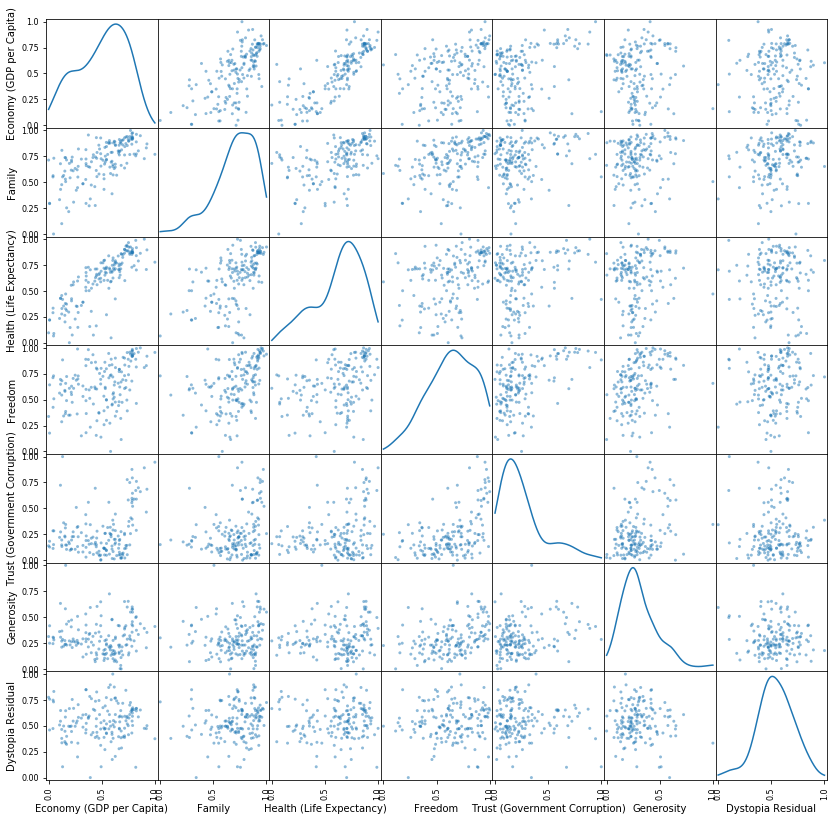

In [54]:
scatter_matrix(prepared_df[num_attr_names], figsize=(14, 14), diagonal='kde');

## Analysis

We will perform a PCA, and want 95 % of the variation explained by the principal components.

In [55]:
pca = PCA(n_components=0.95).fit(prepared_df[num_attr_names])

In [56]:
pd.DataFrame(data=pca.components_, columns=num_attr_names,
             index=(f'factor {i}' for i in range(1, len(pca.components_) + 1)))

,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
factor 1,-0.555693,-0.377036,-0.541984,-0.394331,-0.300629,-0.092451,-0.029680
factor 2,-0.335765,-0.127760,-0.335113,0.528774,0.587147,0.360414,-0.066313
factor 3,0.125246,-0.358359,0.229306,-0.326153,0.288593,0.067628,-0.780433
factor 4,-0.140025,0.161327,0.080067,0.351787,-0.652519,0.470704,-0.420545
factor 5,0.088450,0.517259,-0.464458,0.146912,0.040130,-0.530225,-0.452290
factor 6,0.012856,-0.571232,0.177549,0.558288,-0.189897,-0.541394,-0.033922


Somewhat surprisingly, six components are required to explain 95 % of the variation in the data.  Note that this does not take into account the categorical data, i.e., the region.

In [57]:
pca_df = pd.DataFrame(data=pca.transform(prepared_df[num_attr_names]),
                      columns=(f'factor {i}' for i in range(1, len(pca.components_) + 1)))

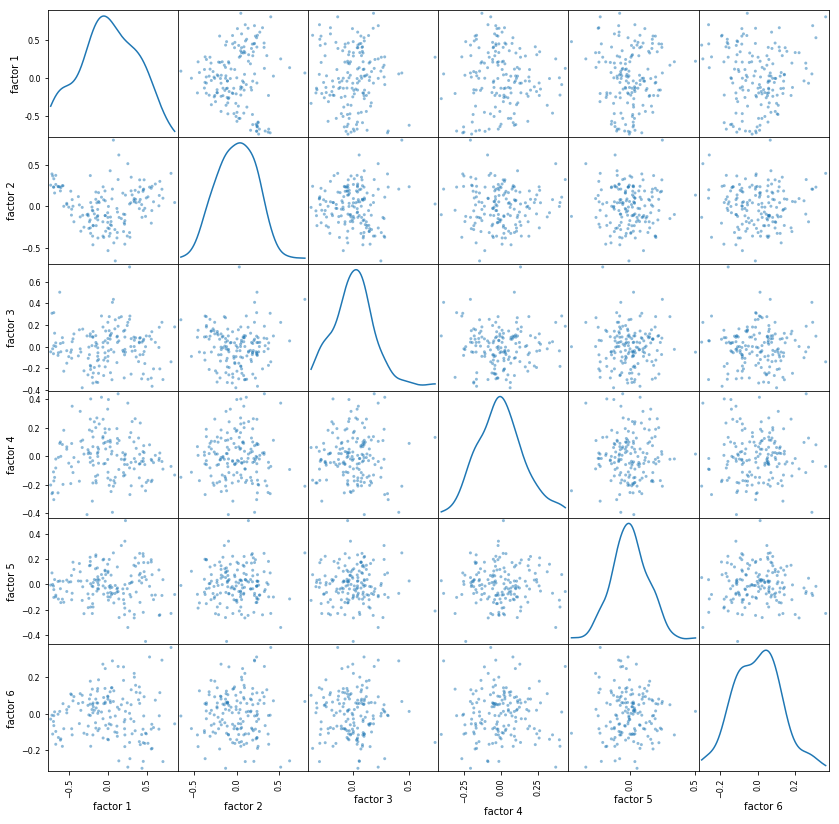

In [58]:
scatter_matrix(pca_df, figsize=(14, 14), diagonal='kde');

There is no obvious correlation visible in the transformed factors, which is indeed expected from the dimensionality reduction.  Given that we can only reduce to six, rather than seven dimensions, we keep working with the original (rescaled) attributes.

## Modelling & training

Try some algorithms, fitting to the 2015 data set happiness score.

In [19]:
X = prepared_data
Y = prepared_output

### Ridge regression

Try the ridge regression learning algorithm first.  This is essentially a linear model with corrections.

In [81]:
rr = Ridge(alpha=0.5, fit_intercept=True)
rr.fit(X, Y);

Check the score on the entire training set.

In [82]:
rr.score(X, Y)

0.9673910670359416

In [83]:
rr.coef_

array([[-0.15126272, -0.78719761, -0.58654832, -0.5557149 , -0.802934  ,
        -0.14198015, -0.68837323, -0.92422303, -1.27994616, -0.34746288,
         1.45072326,  1.05432889,  0.08816192,  0.49369385,  0.61174065,
         0.2533943 ,  2.38253376]])

Compute the error using 10-fold cross validation.

In [84]:
rr_scores = cross_val_score(rr, X, Y, scoring='neg_mean_squared_error', cv=10)

Check the scores.

In [85]:
rmse_rr_scores = np.sqrt(-rr_scores)

In [86]:
print(rmse_rr_scores)

[0.35347243 0.29686273 0.17744627 0.14804794 0.22814386 0.24186935
 0.32189068 0.23895205 0.29704767 0.52456888]


In [87]:
print(np.median(rmse_rr_scores), rmse_rr_scores.std())

0.2693660377273258 0.100607351453494


Compare the happiness socres predicted by the ridge regression learner with the target values in the training data.  Visualize the predictions of the model versus the actual happiness socres for the training data.

In [88]:
Y_rr = rr.predict(X)

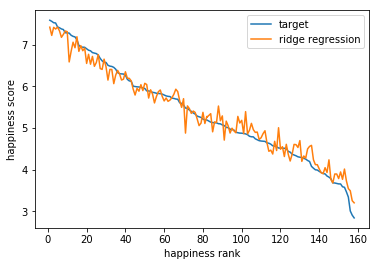

In [89]:
plt.plot(data_2015['Happiness Rank'], Y, label='target')
plt.plot(data_2015['Happiness Rank'], Y_rr, label='ridge regression')
plt.xlabel('happiness rank')
plt.ylabel('happiness score')
plt.legend();

### Fine tuning

In [101]:
grid_params = [
    {'alpha': [0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0],
     'fit_intercept': [True, False]},
]

In [102]:
grid_search = GridSearchCV(rr, grid_params, cv=10, scoring='neg_mean_squared_error', iid=False)

In [103]:
_ = grid_search.fit(X, Y)

In [105]:
grid_search.best_params_

{'alpha': 0.0005, 'fit_intercept': False}

In [107]:
rr_best = Ridge(**grid_search.best_params_).fit(X, Y)

In [108]:
rr_best.score(X, Y)

0.9988255447584871

In [109]:
rr_scores = cross_val_score(rr_best, X, Y, scoring='neg_mean_squared_error', cv=10)

Check the scores.

In [110]:
rmse_rr_scores = np.sqrt(-rr_scores)

In [111]:
print(rmse_rr_scores)

[0.21106328 0.04127874 0.06370151 0.02546311 0.05288048 0.04183254
 0.04704403 0.05889736 0.04790509 0.06226582]


In [112]:
print(np.median(rmse_rr_scores), rmse_rr_scores.std())

0.05039278590325516 0.04980408793318732


In [114]:
Y_rr = rr_best.predict(X)

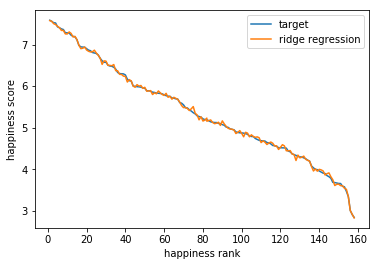

In [115]:
plt.plot(data_2015['Happiness Rank'], Y, label='target')
plt.plot(data_2015['Happiness Rank'], Y_rr, label='ridge regression')
plt.xlabel('happiness rank')
plt.ylabel('happiness score')
plt.legend();

### Random forest

As an alternative, try random forest regression.

In [126]:
rf = RandomForestRegressor(n_estimators=100)

In [127]:
rf.fit(X, Y.ravel());

In [128]:
Y_rf = rf.predict(X)

The score is significantly lower.

In [129]:
rf.score(X, Y)

0.9879561435436927

Visualizing the predictions by the random forrest model versus the actual training data shows fairly large deviations.

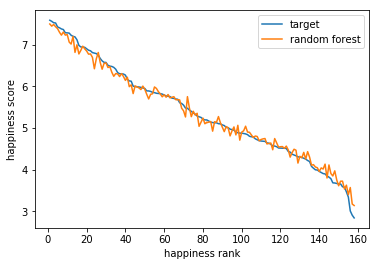

In [130]:
plt.plot(data_2015['Happiness Rank'], Y, label='target')
plt.plot(data_2015['Happiness Rank'], Y_rf, label='random forest')
plt.xlabel('happiness rank')
plt.ylabel('happiness score')
plt.legend();

Cross validation confirms that this model is inferior to ridge regression.

In [131]:
rf_scores = cross_val_score(rf, X, Y.ravel(), scoring='neg_mean_squared_error', cv=10)

In [132]:
rmse_rf_scores = np.sqrt(-rf_scores)

In [133]:
print(rmse_rf_scores)

[0.67958857 0.32522133 0.24075508 0.16166343 0.31012442 0.28522725
 0.2840214  0.22162063 0.42048055 0.83655626]


In [134]:
print(rmse_rf_scores.mean(), rmse_rf_scores.std())

0.37652589101062983 0.204434830638807


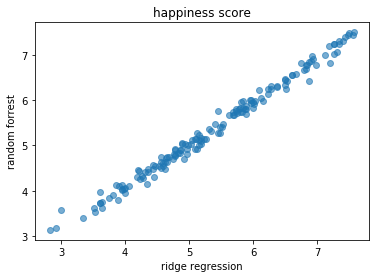

In [135]:
plt.plot(Y_rr, Y_rf, 'o', alpha=0.6)
plt.xlabel('ridge regression')
plt.ylabel('random forrest')
plt.title('happiness score');

### Fine tuning

Perhaps better results can be obtained by a random forest model when its hyperparameters are tuned.

In [136]:
grid_params = [
    {'n_estimators': [100, 200, 300], 'max_features': [8, 10, 12, 14, 16],
     'bootstrap': [False, True]},
]

In [140]:
grid_search = GridSearchCV(rf, grid_params, cv=10, iid=False,
                           scoring='neg_mean_squared_error')

In [141]:
_ = grid_search.fit(X, Y.ravel())

In [142]:
grid_search.best_params_

{'bootstrap': True, 'max_features': 14, 'n_estimators': 200}

In [147]:
rf_best = RandomForestRegressor(**grid_search.best_params_).fit(X, Y.ravel())

In [148]:
rf_best.score(X, Y)

0.9876822554122242

In [149]:
cv_results = grid_search.cv_results_
for mean_score, params in sorted(zip(cv_results['mean_test_score'], cv_results['params']), key=lambda x: x[0], reverse=True):
    print(np.sqrt(-mean_score), params)

0.4355955308164566 {'bootstrap': True, 'max_features': 14, 'n_estimators': 200}
0.4360864800723607 {'bootstrap': True, 'max_features': 16, 'n_estimators': 300}
0.44153929604061476 {'bootstrap': True, 'max_features': 16, 'n_estimators': 200}
0.44237810961619833 {'bootstrap': True, 'max_features': 14, 'n_estimators': 300}
0.4430497525373608 {'bootstrap': True, 'max_features': 16, 'n_estimators': 100}
0.4454897495679548 {'bootstrap': True, 'max_features': 12, 'n_estimators': 300}
0.44589678396962906 {'bootstrap': True, 'max_features': 12, 'n_estimators': 100}
0.44726566588051614 {'bootstrap': True, 'max_features': 14, 'n_estimators': 100}
0.4476034910154746 {'bootstrap': True, 'max_features': 12, 'n_estimators': 200}
0.4495732940232501 {'bootstrap': False, 'max_features': 8, 'n_estimators': 300}
0.44979867892202624 {'bootstrap': True, 'max_features': 10, 'n_estimators': 200}
0.452058495772183 {'bootstrap': False, 'max_features': 10, 'n_estimators': 300}
0.45249239126310614 {'bootstrap': T

In [150]:
Y_rf = rf_best.predict(X)

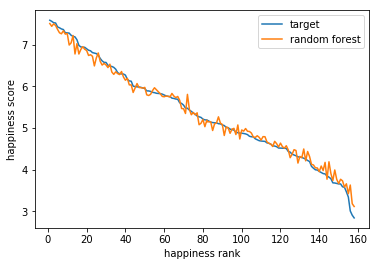

In [151]:
plt.plot(data_2015['Happiness Rank'], Y, label='target')
plt.plot(data_2015['Happiness Rank'], Y_rf, label='random forest')
plt.xlabel('happiness rank')
plt.ylabel('happiness score')
plt.legend();

## Test data

Load the 2016 data set as test data.

In [119]:
data_2016 = pd.read_csv('Data/world_happiness_2016.csv')

Run it through the preprocessing pipeline, note that `transform` should be used, not `fit_transform` since scaling of the numerical attributes should be done using the minima and maxima of the training data, not the test data.

In [120]:
prepared_test_data = preparation_pipeline.transform(data_2016)

In [121]:
X_test = prepared_test_data
Y_test = output_transformer.transform(data_2016)

### Ridge regression

Compute the predictions by the ridge regression model.

In [123]:
Y_test_rr = rr_best.predict(X_test)

In [124]:
rr_best.score(X_test, Y_test)

0.9969294268025323

As expected, the test score is less than the training score, but not by much.

Visualizing the ridge regression predictions illustrates results are quite good.

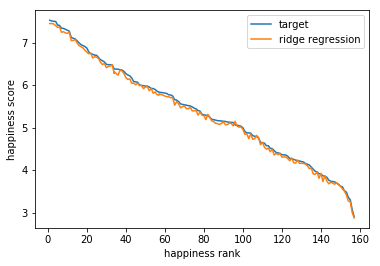

In [125]:
plt.plot(data_2016['Happiness Rank'], Y_test, label='target')
plt.plot(data_2016['Happiness Rank'], Y_test_rr, label='ridge regression')
plt.xlabel('happiness rank')
plt.ylabel('happiness score')
plt.legend();

### Random forest

Compute the random forrest predictions.

In [152]:
Y_test_rf = rf_best.predict(X_test)

The score is significantly lower, and visualization confirms this clearly.

In [153]:
rf_best.score(X_test, Y_test)

0.8870070685221283

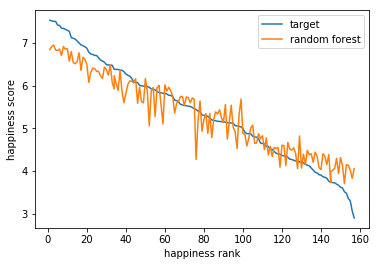

In [154]:
plt.plot(data_2016['Happiness Rank'], Y_test, label='target')
plt.plot(data_2016['Happiness Rank'], Y_test_rf, label='random forest')
plt.xlabel('happiness rank')
plt.ylabel('happiness score')
plt.legend();